## 量子传输和测量模块的展示

在此我们用Qubiter编译/模拟器来展示如何通过一个中间量子比特（比特1）的协助，将一个量子比特（比特0）的纯态传输到另一个量子比特（比特2）。

本文并不旨在讨论或展示量子传输背后的理论。对此感兴趣的读者可以很方便地在网上（维基或者课件）找到对于量子传输的简单推导。以量子传输为例，我们重点展示Qubiter的一些功能，例如测量模块（IF_M blocks）、打印输出，以及量子线路中各种密度矩阵的计算和画图功能。

QUbiter也支持自动生成量子线路的语言文件。感兴趣的读者可以在此找到 <a href="../qubiter_rosetta_stone.pdf"> Qubiter语言文件的详解</a>。


在IBM公司一系列量子计算的展示文档中，也有文档分析了量子态传送的量子传输过程及其量子线路。这些文档是用IBM推出的 qasm 语言组织的，读者可以对qasm语言和Qubiter语言结构进行比较并选用自己喜欢的程序。另外，除了量子编译和量子仿真之外，Qubiter提供了将自身语言转换为IBM qasm语言的子程序，这样通过Qubiter编译后的量子线路可以直接在IBM的量子计算硬件上运行。对其他（例如Rigetti）编译语言和硬件的支持也正在进行中。


首先添加工作目录到系统环境变量：

In [1]:
import os
import sys
print(os.getcwd())
os.chdir('../../')
print(os.getcwd())
sys.path.insert(0,os.getcwd())

C:\Users\rrtuc\Desktop\backedup\python-projects\qubiter\qubiter\jupyter_notebooks
C:\Users\rrtuc\Desktop\backedup\python-projects\qubiter


导入需要的程序包：

In [2]:
from qubiter.SEO_writer import *
from qubiter.SEO_simulator import *
from qubiter.StateVec import *
from qubiter.Plotter import *
import numpy as np
# np.set_printoptions(precision=5)
import pandas as pan
import seaborn as sea; sea.set()

loaded OneBitGates, WITHOUT autograd.numpy



初始化总量子比特数量 为 3，并且用直接的线路嵌入将3个量子比特映射到同样的3个量子比特。（在此我们用"bit"统称量子比特和经典比特）

In [3]:
num_bits = 3
emb = CktEmbedder(num_bits, num_bits)

指定要写入的文件路径，并且采用（ZL-zero bit last）的惯例，即第0个比特在最后的顺序。

In [4]:
file_prefix = 'qubiter/io_folder/teleportation-with-ifs'
wr = SEO_writer(file_prefix, emb)

将量子线路写入为语言文件及图像文件：

In [5]:
# 对第 0 个量子比特旋转任意选取的某个角度，生成初始量子态
wr.write_Rn(0, list(np.pi/180*np.array([20, 68, 46])))
wr.write_PRINT("ALL")

# 对第 1 个量子比特施加Hadamard门 
wr.write_H(1)
# 对第 1、2 个量子比特施加CNOT门，生成bell基 
wr.write_cnot(control_bit=1, target_bit=2)
# wr.write_one_bit_gate(0, OneBitGates.rot_ax, [-np.pi/8, 2])
wr.write_cnot(control_bit=0, target_bit=1)
wr.write_H(0)
wr.write_PRINT("ALL")

# 对量子比特 1、2 做测量
wr.write_MEAS(0, kind=2)
wr.write_MEAS(1, kind=2)

wr.write_PRINT("ALL")
wr.write_IF_M_beg(Controls.new_knob(num_bits, 0, True))
wr.write_Z(2)
wr.write_IF_M_end()
wr.write_PRINT("ALL")
wr.write_IF_M_beg(Controls.new_knob(num_bits, 1, True))
wr.write_X(2)
wr.write_IF_M_end()
wr.write_PRINT("ALL")
    
wr.close_files()

生成的语言文件和图片文件都存储在 io_folder文件夹中：
* <a href="../io_folder/teleportation-with-ifs_3_eng.txt">../io_folder/teleportation-with-ifs_3_eng.txt</a>
* <a href="../io_folder/teleportation-with-ifs_3_ZLpic.txt">../io_folder/teleportation-with-ifs_3_ZLpic.txt</a>

语言文件输出如下：

In [6]:
wr.print_eng_file()

ROTN	20.0	68.0	46.0	AT	0
PRINT	ALL
HAD2	AT	1
SIGX	AT	2	IF	1T
SIGX	AT	1	IF	0T
HAD2	AT	0
PRINT	ALL
MEAS	2	AT	0
MEAS	2	AT	1
PRINT	ALL
IF_M(	0T	){
SIGZ	AT	2
}IF_M
PRINT	ALL
IF_M(	1T	){
SIGX	AT	2
}IF_M
PRINT	ALL




输出图片文件，其中每一行都是和语言文件中一一对应的。

这里时间箭头方向为下，由于我们采取了ZL惯例，第0个量子比特在最右边。

另外，在对一个量子比特进行过测量之后（例如第九行），之前的"|"量子演化被":"符号所替代。


In [7]:
wr.print_pic_file()

|   |   R   
PRINT	ALL
|   H   |   
X---@   |   
|   X---@   
|   |   H   
PRINT	ALL
|   |   M   
|   M   :   
PRINT	ALL
IF_M(	0T	){
Z   :   :   
}IF_M
PRINT	ALL
IF_M(	1T	){
X   :   :   
}IF_M
PRINT	ALL



现在我们模拟制备一个初始态，其中所有量子态处于基态|0>，并且让模拟器从初态到末态演化。

其中在量子线路中插入的“打印输出”功能会将在当时的量子线路状态打印输出到屏幕。每个输出指令都有对应的行代码来进行标识。

In [8]:
init_st_vec = StateVec.get_ground_st_vec(num_bits)
sim = SEO_simulator(file_prefix, num_bits, init_st_vec)


*************************beginning PRINT output
PRINT line number=2
*********branch= pure
state vector:
ZL convention (Zero bit Last in state tuple)
(000)ZL (0.09587145233013179+0.5418806258342269j) , prob= 0.3028259480263821
(001)ZL (-0.8010409251462487+0.23560027210183782j) , prob= 0.697174051973618
total probability of state vector (=one if no measurements)= 1.0000000000000002
dictionary with key=qubit, value=(Prob(0), Prob(1))
{0: (0.30282594802638213, 0.6971740519736178),
 1: (1.0000000000000002, -2.220446049250313e-16),
 2: (1.0000000000000002, -2.220446049250313e-16)}
****************************ending PRINT output

*************************beginning PRINT output
PRINT line number=7
*********branch= pure
state vector:
ZL convention (Zero bit Last in state tuple)
(000)ZL (0.04793572616506589+0.2709403129171134j) , prob= 0.07570648700659549
(100)ZL (-0.4005204625731243+0.11780013605091888j) , prob= 0.17429351299340448
(010)ZL (-0.4005204625731243+0.11780013605091888j) , prob= 0.1

所有的量子比特初始态为|0>。

量子线路的第1行对量子比特0做了随意选取角度的旋转。

量子线路的第2行为打印输出操作。

接下来我们将第二行的量子态存储为密度矩阵den_mat1，并且用Pandas数据库存储和展示这个密度矩阵。其中量子基矢仍然采用ZL(第0在最后)的惯例。



In [9]:
# density  matrix cached at line number 2 of eng & pic files
den_mat1 = StateVec.get_den_mat(num_bits, sim.cached_sts[2])
den_mat1_df = Plotter.get_den_mat_df(num_bits, den_mat1)
# pan.set_option('precision', 5)
# print("\nden_mat1=\n", den_mat1_df)
den_mat1_df.style.format("{:.4}")

,000ZL,001ZL,010ZL,011ZL,100ZL,101ZL,110ZL,111ZL
000ZL,(0.3028+0j),(0.05087-0.4567j),0j,0j,0j,0j,0j,0j
001ZL,(0.05087+0.4567j),(0.6972+0j),0j,0j,0j,0j,0j,0j
010ZL,0j,0j,0j,0j,0j,0j,0j,0j
011ZL,0j,0j,0j,0j,0j,0j,0j,0j
100ZL,0j,0j,0j,0j,0j,0j,0j,0j
101ZL,0j,0j,0j,0j,0j,0j,0j,0j
110ZL,0j,0j,0j,0j,0j,0j,0j,0j
111ZL,0j,0j,0j,0j,0j,0j,0j,0j


之后，我们将模拟器演变的末态存储为密度矩阵den_mat2，并且用pandas数据结构存储和展示：

In [10]:
den_mat2 = StateVec.get_den_mat(num_bits, sim.cur_st_vec_dict)
den_mat2_df = Plotter.get_den_mat_df(num_bits, den_mat2)
# print("\nden_mat2=\n", den_mat2_df)
den_mat2_df.style.format("{:.3}")

,000ZL,001ZL,010ZL,011ZL,100ZL,101ZL,110ZL,111ZL
000ZL,(0.0757+0j),0j,0j,0j,(0.0127-0.114j),0j,0j,0j
001ZL,0j,(0.0757+0j),0j,0j,0j,(0.0127-0.114j),0j,0j
010ZL,0j,0j,(0.0757+0j),0j,0j,0j,(0.0127-0.114j),0j
011ZL,0j,0j,0j,(0.0757+0j),0j,0j,0j,(0.0127-0.114j)
100ZL,(0.0127+0.114j),0j,0j,0j,(0.174+0j),0j,0j,0j
101ZL,0j,(0.0127+0.114j),0j,0j,0j,(0.174+0j),0j,0j
110ZL,0j,0j,(0.0127+0.114j),0j,0j,0j,(0.174+0j),0j
111ZL,0j,0j,0j,(0.0127+0.114j),0j,0j,0j,(0.174+0j)


更直观的，密度矩阵也可以通过quiver画图被表示为向量箭头的形式。

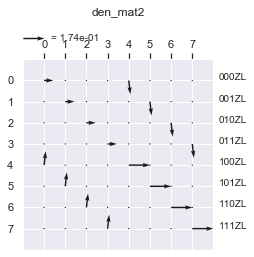

In [11]:
Plotter.plot_phasors(['den_mat2'], den_mat_df_list=[den_mat2_df])

接下来将密度矩阵den_mat2中的值替换为模，并且将数据输出：


In [12]:
df = den_mat2_df.apply(lambda x : np.sqrt(np.real(x*np.conj(x))))
df

,000ZL,001ZL,010ZL,011ZL,100ZL,101ZL,110ZL,111ZL
000ZL,0.075706,0.000000,0.000000,0.000000,0.114870,0.000000,0.000000,0.000000
001ZL,0.000000,0.075706,0.000000,0.000000,0.000000,0.114870,0.000000,0.000000
010ZL,0.000000,0.000000,0.075706,0.000000,0.000000,0.000000,0.114870,0.000000
011ZL,0.000000,0.000000,0.000000,0.075706,0.000000,0.000000,0.000000,0.114870
100ZL,0.114870,0.000000,0.000000,0.000000,0.174294,0.000000,0.000000,0.000000
101ZL,0.000000,0.114870,0.000000,0.000000,0.000000,0.174294,0.000000,0.000000
110ZL,0.000000,0.000000,0.114870,0.000000,0.000000,0.000000,0.174294,0.000000
111ZL,0.000000,0.000000,0.000000,0.114870,0.000000,0.000000,0.000000,0.174294


此数据全部由非零的数据构成，所以可以通过seaborn工具包用heatmap表示：

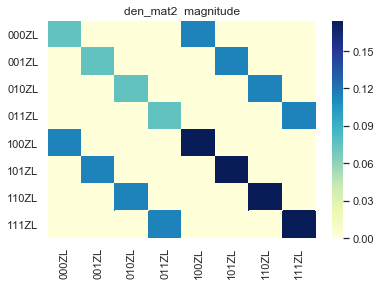

In [13]:
plt.close('all')
ax = sea.heatmap(df, cmap="YlGnBu")
ax.set_title('den_mat2  magnitude')
plt.yticks(rotation=0) 
plt.xticks(rotation=90)
plt.show()

密度矩阵$\rho$的非纯度由$ abs({\rm tr}(\rho^2) - 1 )$ 定义。当密度矩阵$\rho$为纯态时此值为零。而目前模拟器的末态den_mat2并非一个纯态。


In [14]:
print("impurity of den_mat2=", StateVec.get_impurity(den_mat2))

impurity of den_mat2= 0.75


下一步我们对密度矩阵关于比特0和1求迹，并得到约化密度矩阵tr01_den_mat2.此约化密度矩阵也可以通过dataframe展示出来。可以看到，初始的量子比特0的密度矩阵den_mat1已经被成功的转移到量子比特2的密度矩阵tr01_den_mat2，意味着量子态成功的从比特0传输到比特2.

In [15]:
tr01_den_mat2 = StateVec.get_partial_tr(num_bits, den_mat2, {0, 1})
tr01_den_mat2_df = Plotter.get_den_mat_df(1, tr01_den_mat2)
# print("\ntr01_den_mat2=\n", tr01_den_mat2_df)
tr01_den_mat2_df.style.format("{:.4}")

,0,1
0,(0.3028+0j),(0.05087-0.4567j)
1,(0.05087+0.4567j),(0.6972+0j)


可以验证，密度矩阵tr01_den_mat2 描述一个和初始态同样的纯态。其非纯度为0：

In [16]:
print("impurity of tr01_den_mat2=", StateVec.get_impurity(tr01_den_mat2))

impurity of tr01_den_mat2= 2.220446049250313e-16
